$\Delta u + k^2(1+q) u = f $ in $\Omega = [0,1]^2$    
$u = 0 $ on $\partial \Omega$

In [2]:
import scipy as sp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import gmres,lgmres
import time

In [3]:
k = 1  # wavenumber
N = 50  # 格点数
h = 1 / N  # 间隔

In [4]:
def q_gen_example(N):
    q = np.zeros((N + 1, N + 1))
    q_value = 0.02
    x1, x2, x3, y1, y2, y3, y4 = 0.2, 0.4, 0.7, 0.2, 0.3, 0.6, 0.7
    q[int(x1 * N):int(x2 * N), int(y1 * N):int(y4 * N)] = q_value
    q[int(x2 * N):int(x3 * N), int(y2 * N):int(y3 * N)] = q_value
    return q

def q_gen_1(N,b1 = 0.3,b2 = 0.6,a1 = 8,a2 = 9,gamma = 1): # 𝑞(𝑥,𝑦)= 𝜆   exp⁡(−𝑎1(𝑥−𝑏1 )^2−a2 (y−b2 )^2 ) 

    q = np.zeros((N + 1, N + 1))
    for i in range(1,N):
        for j in range(1,N):
            q[i,j] = gamma* np.exp(-a1*(i/N - b1)**2-a2*(j/N - b2)**2)
    return q

def q_generation(N, method='T'): 
    if method == 'T':
        return q_gen_example(N)
    elif method == 'Gauss':
        return q_gen_1(N)
    print('method error')


# q = q_generation(N)
# sns.heatmap(q, xticklabels=False, yticklabels=False)

$u = \sin(x\pi)\sin(y\pi)$  
$f = \Delta u + (1+q) u = (1+q-2\pi^2)u$

In [5]:
def u_gen(N):
    u = np.zeros((N+1,N+1))
    for i in range(1,N):
        for j in range(1,N):
            u[i,j] = np.sin(i*np.pi/N)*np.sin(j*np.pi/N)
    return u

# u_truth = u_gen(N)
# sns.heatmap(u_truth, xticklabels=False, yticklabels=False)

In [6]:
def f_gen_1(N,q,u,k = 1):
    return ((1+q)*k*k-2*np.pi*np.pi)*u

# f = f_gen_1(N,q,u_truth)
# sns.heatmap(f, xticklabels=False, yticklabels=False)

### Method2 九点格式
$A \,u_{i,j} = u_{i+1,j} +u_{i-1,j} +u_{i,j+1} +u_{i,j-1}  $  
$\frac{A-4I}{h^2} u_{i,j} + k^2(1+q_{i,j})u_{i,j} = f_{i,j} $ 
$B \,u_{i,j} = u_{i+1,j+1} +u_{i-1,j-1} +u_{i-1,j+1} +u_{i+1,j-1}$  
$\frac{A-4I}{h^2} u_{i,j} + \frac{B - 2A+4I}{6h^2}u_{i,j} + k^2(1+q_{i,j})u_{i,j} + \frac{k^2}{12}(A-4I)
(1+q_{i,j})u_{i,j}= f_{i,j} + \frac{1}{12}(A-4I)f_{i,j}$  
$\Rightarrow\quad (B+4A-20I) u_{i,j} +h^2 k^2(0.5A+4I)
(1+q_{i,j})u_{i,j}= h^2 (0.5A+4I)f_{i,j}$

In [7]:
def A(v):
    v[0, :] = 0
    v[-1, :] = 0
    v[:, 0] = 0
    v[:, -1] = 0
    return v[1:-1, 2:] + v[:-2, 1:-1] + v[2:, 1:-1] + v[1:-1, :-2]


def Matrix_9(N, q, k=1):
    M = N - 1
    h = 1 / N

    Q = q[1:-1, 1:-1].reshape(1, -1)

    value_1 = (1 + Q) * h * h * k * k * 4 - 20  # 主对角线
    value_2 = 4 + 0.5 * h * h * k * k * (1 + q[1:-1, 1:-1])  # A 三对角线&主对角元三对角线

    data_main = value_1  # 主对角线
    data_main_up = np.reshape(np.c_[np.zeros((M, 1)), value_2[:, :-1]],
                              (1, -1))  # 主对角元上对角线
    data_main_down = np.reshape(np.c_[value_2[:, 1:],
                                      np.zeros((M, 1))], (1, -1))  # 主对角元下对角线
    data_up = np.c_[np.zeros((1, M)), value_2[:-1, :].reshape(1,
                                                              -1)]  # 上对角元对角线
    data_up_up = np.tile(np.insert(np.ones(M - 1), 0, 0),
                         M).reshape(1, -1)  # 上对角元上对角线
    data_up_down = np.tile(np.append(np.ones(M - 1), 0),
                           M).reshape(1, -1)  # 上对角元下对角线
    data_down = np.c_[value_2[1:, :].reshape(1, -1), np.zeros((1, M))]  # 下对角元
    data_down_up = data_up_up  # 下对角元上对角线
    data_down_down = data_up_down  # 下对角元下对角线
    data = np.r_[data_main, data_main_up, data_main_down, data_up, data_up_up,
                 data_up_down, data_down, data_down_up, data_down_down]
    offsets = np.array([0, 1, -1, M, M + 1, M - 1, -M, -M + 1, -M - 1])
    dia = sp.sparse.dia_matrix((data, offsets), shape=(M * M, M * M))
    return dia

In [8]:
def perform(N, q_method = 'T',k = 1,tol=1e-05, inner_m=30,x0 = None):
    def Error(a, a_truth, gap=1e-10):
        a1 = np.where(a < gap, gap, a)
        a_t1 = np.where(a_truth < gap, gap, a_truth)
        return np.abs(a1 / a_t1 - 1)

    q = q_generation(N,q_method)
    u_truth = u_gen(N)
    f = f_gen_1(N, q, u_truth,k = k)
    h = 1 / N
    
    time90 = time.time()
    Matrix9 = Matrix_9(N, q,k = k)
    Right9 = ((0.5 * A(f) + 4 * f[1:-1, 1:-1]) * h * h).reshape((-1, 1))
    u_res, exit = lgmres(Matrix9, Right9, atol=tol,inner_m=inner_m,x0 = x0)
    time91 = time.time() - time90
    if exit == 0:
        res9 = np.zeros((N + 1, N + 1))
        res9[1:-1, 1:-1] = u_res.reshape(N - 1, N - 1)
        err9 = np.linalg.norm(Error(res9, u_truth), ord=2) / (N - 1)
    else:
        print('九点格式不收敛')
    
    print('N = %d' % N)
    print('九点格式平均相对误差为%f,求解用时%f' % (err9, time91))

In [9]:
perform(100)

N = 100
九点格式平均相对误差为0.000007,求解用时0.031422


In [21]:
perform(50)

N = 50
九点格式平均相对误差为0.000001,求解用时0.010584


In [22]:
perform(200)

N = 200
九点格式平均相对误差为0.000012,求解用时0.141410


In [25]:
perform(200,tol=1e-03)

N = 200
九点格式平均相对误差为0.000433,求解用时0.023342


In [41]:
perform(400,inner_m=10)

N = 400
九点格式平均相对误差为0.000029,求解用时0.775286


In [10]:
perform(200,k = 10)

N = 200
九点格式平均相对误差为0.000173,求解用时4.325731


In [11]:
perform(200,q_method='Gauss')

N = 200
九点格式平均相对误差为0.000016,求解用时0.235781


In [35]:
N = 200
q_method = 'T'
k = 10
tol=1e-05
inner_m=30
q = q_generation(N,q_method)
u_truth = u_gen(N)
f = f_gen_1(N, q, u_truth,k = k)
h = 1 / N


<AxesSubplot:>

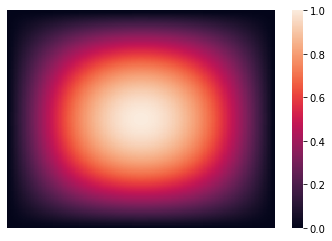

In [36]:
sns.heatmap(u_truth, xticklabels=False, yticklabels=False)

<AxesSubplot:>

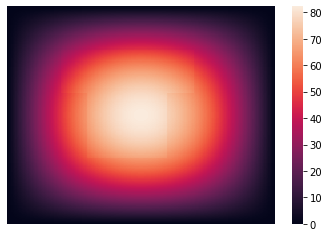

In [37]:
sns.heatmap(f, xticklabels=False, yticklabels=False)

In [38]:
Matrix9 = Matrix_9(N, q,k = k)
Right9 = ((0.5 * A(f) + 4 * f[1:-1, 1:-1]) * h * h).reshape((-1, 1))
u_res, exit = lgmres(Matrix9, Right9, atol=tol,inner_m=inner_m)
res9 = np.zeros((N + 1, N + 1))
res9[1:-1, 1:-1] = u_res.reshape(N - 1, N - 1)
err9 = np.linalg.norm(Error(res9, u_truth), ord=2) / (N - 1)

NameError: name 'Error' is not defined

<AxesSubplot:>

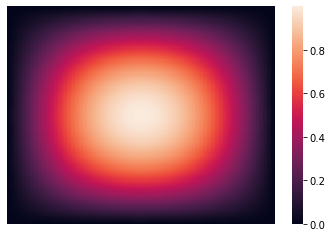

In [39]:
sns.heatmap(res9, xticklabels=False, yticklabels=False)